# Proper GPs
Much here changed with the help of the `Flux Experimentation.ipynb` notebook. I'll try to make pretty, functional GPs here.

In [109]:
using LinearAlgebra
using Plots
using Distributions
using Random; Random.seed!(1234);

In [1]:
zero_mean() = x -> zeros(size(x))
constant_mean(m) = x -> zeros(size(x)) .+ m
rbf(l, σ_f) = 
    (x₁, x₂) -> σ_f.^2 .* exp.(- (x₁ .- x₂').^2 ./ l.^2)
noise(σ_n) = 
    (x₁, x₂) -> (x₁ .== x₂') * σ_n[1]^2
struct GP
    μ
    k
end
GP(k) = GP(zero_mean(), k)

GP

In [2]:
gp = GP(rbf([1.], [1.]), 0.1)

GP(getfield(Main, Symbol("##3#4"))(), getfield(Main, Symbol("##7#8")){Array{Float64,1},Array{Float64,1}}([1.0], [1.0]), 0.1)

## Prior
Defined by making the GP callable.

In [112]:
function (gp::GP)(X)
    return MultivariateNormal(gp.μ(X), Symmetric(gp.k(X, X) + 1e-6I))
end

In [113]:
Xs = 0:0.01:10
prior_distribution = gp(Xs)

FullNormal(
dim: 1001
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [1.0 0.9999 … 4.54326e-44 3.72008e-44; 0.9999 1.0 … 5.54748e-44 4.54326e-44; … ; 4.54326e-44 5.54748e-44 … 1.0 0.9999; 3.72008e-44 4.54326e-44 … 0.9999 1.0]
)


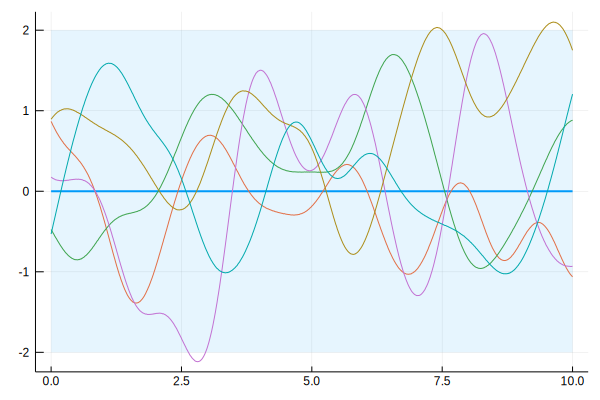

In [114]:
plot(
    Xs, prior_distribution.μ, 
    width=2, 
    ribbon=2sqrt.(diag(prior_distribution.Σ)), 
    fillalpha=0.1, 
    leg=false,
)
plot!(Xs, rand(prior_distribution, 5))

## Posterior Sample
First generate some evidence from a single GP sample.

Then condition the GP on this evidence and plot the mean, variance, and some samples from this conditioned GP.

In [119]:
gen_f = GP(constant_mean(-1.), rbf([0.5], [2]))
n = 10
gen_f_dist = gen_f(Xs)
idx = sample(1:length(Xs), n)
X = Xs[idx]
full_f = rand(gen_f_dist)
f_vect = full_f[idx]

10-element Array{Float64,1}:
 -1.3025730126807127
 -1.9734802882567508
 -2.121372115477485 
 -1.5781767130679076
 -0.123665990552975 
 -1.3434501266674082
  0.7942225928172713
 -1.8629297993381018
 -0.2745155101926412
 -2.1979243921053246

In [120]:
function posterior(gp, X, y, σ_n)     
    Δy = y - gp.μ(X)
    K_inv = inv(Symmetric(gp.k(X, X) + σ_n.^2 * I + 1e-6*I))
    
    μ(x) = gp.μ(x) .+ gp.k(x, X) * K_inv * Δy
    k(x₁, x₂) = gp.k(x₁, x₂) - gp.k(x₁, X) * K_inv * gp.k(X, x₂)
    
    return GP(μ, k)
end

posterior (generic function with 2 methods)

In [121]:
posterior_gp = posterior(gp, X, f_vect, 0.0)
posterior_distribution = posterior_gp(Xs)

FullNormal(
dim: 1001
μ: [-1.67749, -1.6843, -1.69057, -1.69627, -1.7014, -1.70594, -1.70987, -1.71318, -1.71585, -1.71788  …  -0.404518, -0.394044, -0.383763, -0.373672, -0.363771, -0.354059, -0.344535, -0.335198, -0.326046, -0.317079]
Σ: [0.289923 0.283995 … 2.76512e-5 2.69492e-5; 0.283995 0.278219 … 2.75189e-5 2.68202e-5; … ; 2.76512e-5 2.75189e-5 … 0.972706 0.973349; 2.69492e-5 2.68202e-5 … 0.973349 0.974174]
)


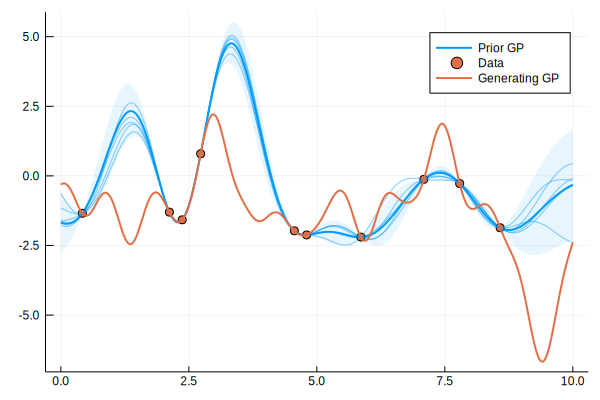

In [123]:
plot(
    Xs, posterior_distribution.μ, 
    width=2, 
    ribbon=2sqrt.(diag(posterior_distribution.Σ)), 
    fillalpha=0.1, 
    label="Prior GP"
)
scatter!(X, f_vect, label="Data", color=2)
plot!(Xs, rand(posterior_distribution, 5), 
    label="",
    color=1, alpha=0.5,
)

plot!(Xs, full_f, width=2,  
    fillalpha=0.1, 
    label="Generating GP",
    color=2
)

## Better way to add evidence

Roughly, we want to express that the GP evaluated at X has values y.
In Stheno this is written as gp(X) $\leftarrow$ y.

In [124]:
function ←(gp::GP, obs::Tuple{Array, Array})
    X, y = obs
    Δy = y - gp.μ(X)
    K_inv = inv(Symmetric(gp.k(X, X) + σ_n.^2 * I + 1e-6*I))
    
    μ(x) = gp.μ(x) .+ gp.k(x, X) * K_inv * Δy
    k(x₁, x₂) = gp.k(x₁, x₂) - gp.k(x₁, X) * K_inv * gp.k(X, x₂)
    
    return GP(μ, k)
end

← (generic function with 4 methods)

In [127]:
post_gp = gp ← (X, f_vect)

GP(getfield(Main, Symbol("#μ#65")){GP,Array{Float64,1},Array{Float64,1},Symmetric{Float64,Array{Float64,2}}}(GP(getfield(Main, Symbol("##53#54"))(), getfield(Main, Symbol("##57#58")){Array{Float64,1},Array{Float64,1}}([1.0], [1.0])), [2.12, 4.56, 4.8, 2.37, 7.09, 0.42, 2.73, 8.58, 7.79, 5.86], [-1.30257, -1.97348, -2.12137, -1.57818, -0.123666, -1.34345, 0.794223, -1.86293, -0.274516, -2.19792], [28.2392 -2.03924 … -0.0525124 -0.24598; -2.03924 11.2987 … 0.358445 1.65924; … ; -0.0525124 0.358445 … 2.57322 0.351997; -0.24598 1.65924 … 0.351997 1.46086]), getfield(Main, Symbol("#k#66")){GP,Array{Float64,1},Symmetric{Float64,Array{Float64,2}}}(GP(getfield(Main, Symbol("##53#54"))(), getfield(Main, Symbol("##57#58")){Array{Float64,1},Array{Float64,1}}([1.0], [1.0])), [2.12, 4.56, 4.8, 2.37, 7.09, 0.42, 2.73, 8.58, 7.79, 5.86], [28.2392 -2.03924 … -0.0525124 -0.24598; -2.03924 11.2987 … 0.358445 1.65924; … ; -0.0525124 0.358445 … 2.57322 0.351997; -0.24598 1.65924 … 0.351997 1.46086]))

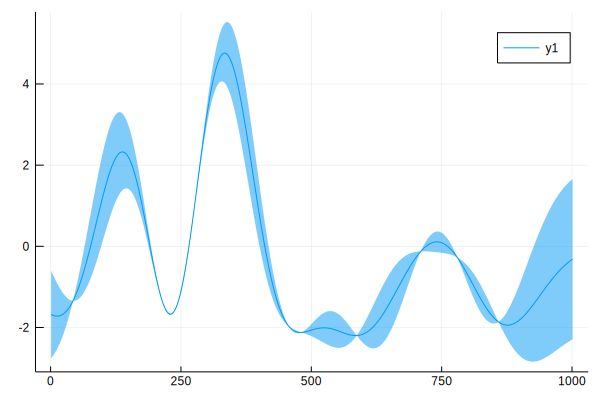

In [128]:
plot(post_gp(Xs).μ, ribbon=2*diag(post_gp(Xs).Σ).^(1/2))